# Use iRF to find the genes that best represent the learned PPs 

In [73]:
import irf
from irf.ensemble import wrf_reg, wrf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import inspect
from irf.utils import get_prevalent_interactions

In [2]:
#load_data
tmp = np.load('../data/imputed_data_kNN_neighbor_6_weights_distance.npz')
data = tmp['imputed']
selected = tmp['selected']
original_shape = data.shape

In [3]:
#load reference atlas
areas_atlas = np.load('mouse_coarse_structure_atlas.npy')
mouse_coarse_df = pd.read_pickle('mouse_coarse_df')

In [4]:
# preprocess compute the support
support = np.sum(areas_atlas, 0) > 0

In [5]:
# preprocess : get the data within the reference atlas
filtered_data = data[:,:-1,:-1,:-1][:, support]
filtered_data.shape

(4345, 55954)

In [30]:
tmp = np.load('../data/mouse_brain_ISH_float32.npz', allow_pickle=True)
sections = tmp['sections'].item()
gene_ids = list(sections.keys())

In [35]:
PP_new_order = (9,6,7,0,5,2,8,4,11,12,1,3,10)
def reorder_PPs(PPs_3d):
    PPs_3d_reordered = PPs_3d.copy()
    for i in range(13):
        PPs_3d_reordered[i] = PPs_3d[PP_new_order[i]]
    return PPs_3d_reordered

In [36]:
# load
with open("./nmf_model_final.pickle", 'rb') as f:
    nmf = pickle.load(f)
    
nmf.components_ = reorder_PPs(nmf.components_) # reorder

# normalize each PP to have unit L2 norm
for i in range(13):
    nmf.components_[i] = nmf.components_[i] / np.sqrt(np.sum(nmf.components_[i] ** 2))

<hr/>
## use iRF-loop to construct network

In [21]:
def filter_genes(coefs, pps, threshold = .99):
    large_coefs = np.max(coefs[:, pps], 1) 
    return large_coefs > np.quantile(large_coefs, threshold)

In [22]:
def show_graph_with_labels(adjacency_matrix, mylabels, colors, title=""):
    plt.figure(figsize=(10,7))
    rows, cols = np.where(adjacency_matrix > 0)
    edges = [(x, y) for x, y in zip(rows.tolist(), cols.tolist()) if x > y]
    edge_colors = np.array([adjacency_matrix[edge[0], edge[1]] for edge in edges])
    gr = nx.Graph()
    gr.add_edges_from(edges)
    
    remove = [node for node,degree in gr.degree() if degree <= 0.5]
    colors = [x for x, y in zip(colors, gr.degree()) if y[1] > 0.5]
    edge_colors = [y for x, y in zip(edges, edge_colors) if gr.degree()[x[0]] > 0.5 and gr.degree()[x[1]] > 0.5]
    
    gr.remove_nodes_from(remove)
    nodes = set(ind for ind, name in gr.degree())
    pos = nx.circular_layout(gr)
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    nx.draw(
        gr,
        pos,
        node_size=100,
        labels={k:v for k, v in mylabels.items() if k in gr},
        node_color=colors,
        with_labels=False,
        cmap=plt.cm.copper_r,
    )
    nx.draw_networkx_edges(
        gr,
        pos,
        gr.edges(),
        edge_color=edge_colors,
        edge_cmap=plt.cm.Greys,
    )
    description = nx.draw_networkx_labels(gr,{k:(v[0] * 1.3, v[1] * 1.3) for k, v in pos.items()},labels={k:v for k, v in mylabels.items() if k in gr})
    sm = plt.cm.ScalarMappable(cmap=plt.cm.copper_r, norm=plt.Normalize(vmin = np.min(colors), vmax=np.max(colors)))
    sm._A = []
    plt.colorbar(sm)
    plt.title(title)
    plt.savefig("network_{}.png".format(title))
    plt.show()

In [63]:
class iRF_loop:
    def __init__(self, rf, combination_rule='max', sample_weight=None, threshold=0.01):
        self.rf=rf
        assert combination_rule in ['max', 'min', 'mean'], 'combination rule can only be max/min/mean.'
        self.combination_rule = combination_rule
        self.sample_weight = sample_weight
        self.threshold = threshold
        
    def fit(self, X):
        self.similarity_matrix = np.zeros(shape=(X.shape[1], X.shape[1]))
        for i in range(X.shape[1]):
            y = X[:,i]
            selected = [True] * X.shape[1]
            selected[i] = False
            Xtrain = X[:,selected]
            self.rf.fit(Xtrain, y, sample_weight=self.sample_weight)
            self.similarity_matrix[i,selected] = self.rf.feature_importances_
        return self.similarity_matrix
    def show(self, node_names, colors, title):
        edge_matrix = np.zeros_like(self.similarity_matrix)
        if self.combination_rule == 'max':
            edge_matrix = np.maximum(self.similarity_matrix, self.similarity_matrix.T)
        elif self.combination_rule == 'min':
            edge_matrix = np.minimum(self.similarity_matrix, self.similarity_matrix.T)
        elif self.combination_rule == 'mean':
            edge_matrix = (self.similarity_matrix + self.similarity_matrix.T) / 2
        show_graph_with_labels(
            edge_matrix * (edge_matrix > self.threshold),
            {ind: name for ind, name in enumerate(node_names)}, 
            colors=colors,
            title=title,
        )

In [59]:
class RF(wrf_reg):
    def fit(self, X, y, sample_weight=None):
        super(RF, self).fit(X, y, sample_weight=sample_weight, K=3, keep_record=False)
rf = RF(
    bootstrap=True,
    n_estimators=10,
    n_jobs=-1,
)

In [32]:
X_guess = np.maximum(data[:,:-1,:-1,:-1][:,support], 0)
unique_gene_names = np.unique(list(sections.values()))

unique_X = np.zeros((len(unique_gene_names), X_guess.shape[1]))

for ind, name in enumerate(unique_gene_names):
    gene_ids = np.where([x == name for x in sections.values()])[0]
    #print(gene_ids)
    unique_X[ind,:] = np.mean(X_guess[gene_ids,:], 0)
# solve the coefs, this code takes some time
unique_coefs = nmf.transform(unique_X)

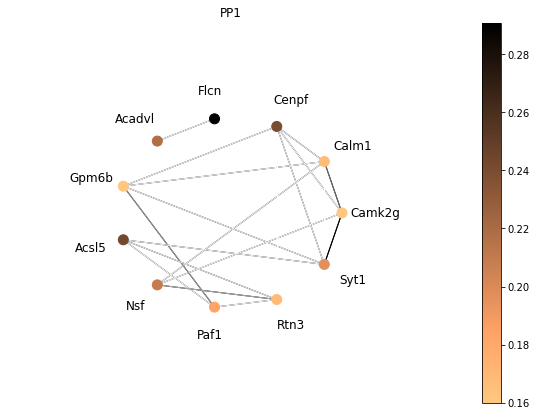

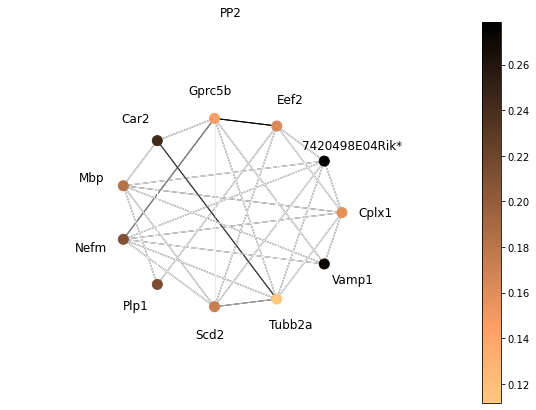

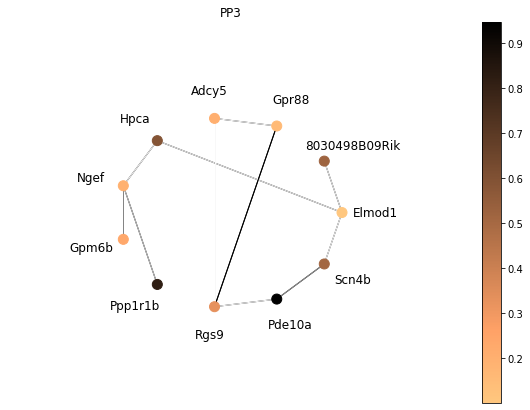

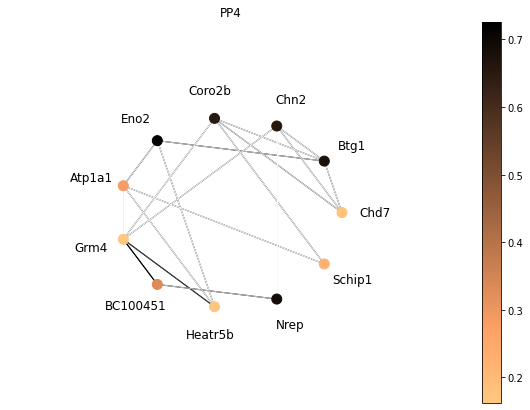

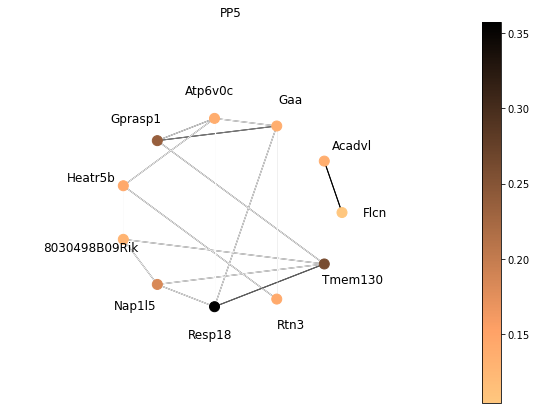

In [67]:
rf_loop = iRF_loop(rf=rf, combination_rule='min', threshold=0.05)
for i in range(13):
    pps = [i]
    weights = np.mean(nmf.components_[pps], 0)
    selected_gene_ids = filter_genes(unique_coefs, pps, threshold=0.9975)
    X_of_interest = unique_X[selected_gene_ids,:].T
    selected_gene_names = unique_gene_names[selected_gene_ids]
    colors = (
        unique_coefs[selected_gene_ids, pps[0]]/
        np.sum(unique_coefs[selected_gene_ids], axis=1)
    )
    subsampling = np.random.choice(np.arange(X_of_interest.shape[0]), 3000, replace=False)
    rf_loop.fit(X_of_interest[subsampling])
    rf_loop.show(node_names=selected_gene_names, colors=colors, title=f"PP{i+1}")
    if i > 3:
        break

<hr />
# Use iRF to get the prediction

In [82]:
class new_iRF(iRF_loop):
    def fit(self, X):
        self.similarity_matrix = np.zeros(shape=(X.shape[1], X.shape[1]))
        for i in range(X.shape[1]):
            y = X[:,i]
            selected = [True] * X.shape[1]
            selected[i] = False
            Xtrain = X[:,selected]
            self.rf.fit(Xtrain, y, sample_weight=self.sample_weight)
            sets = get_prevalent_interactions(
                self.rf,
                impurity_decrease_threshold=0,
                adjust_for_weights=True,
                signed=True,
                min_support=self.rf.n_paths // 2 ** 4,
            )
            averaged = np.zeros(shape=(X.shape[1]-1))
            for interact in sets.keys():
                for f in interact:
                    if isinstance(f, tuple):
                        averaged[f[0]] += 1
                    else:
                        averaged[f] += 1
            averaged = averaged / averaged.sum()
            self.similarity_matrix[i,selected] = averaged
        return self.similarity_matrix

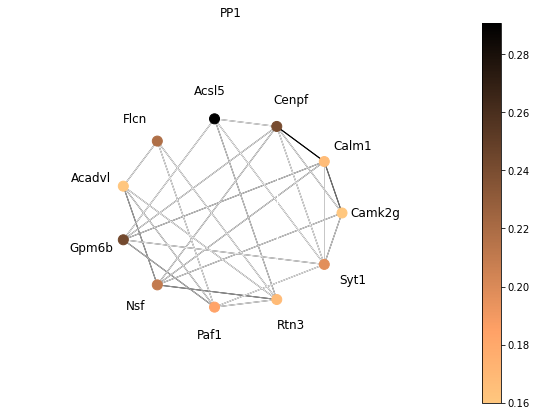

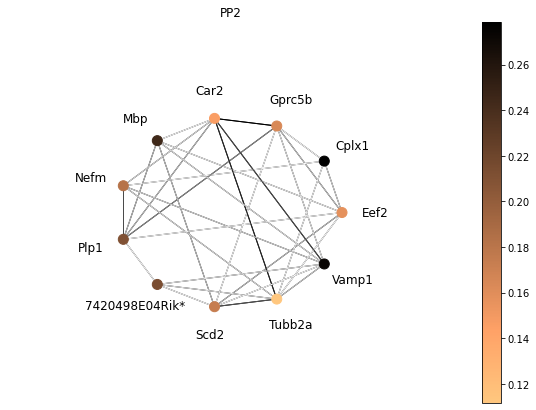

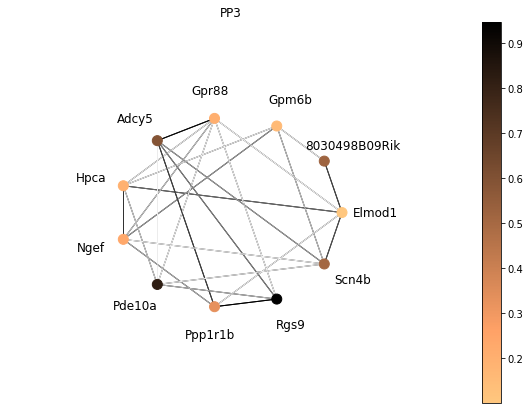

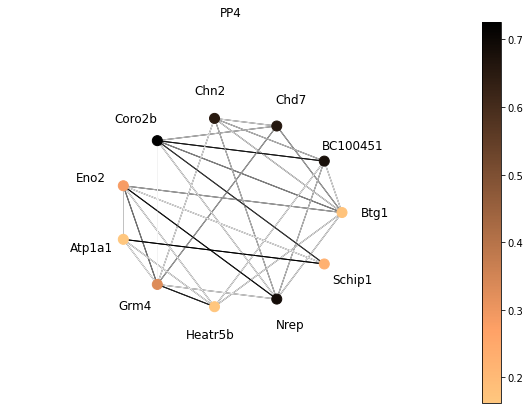

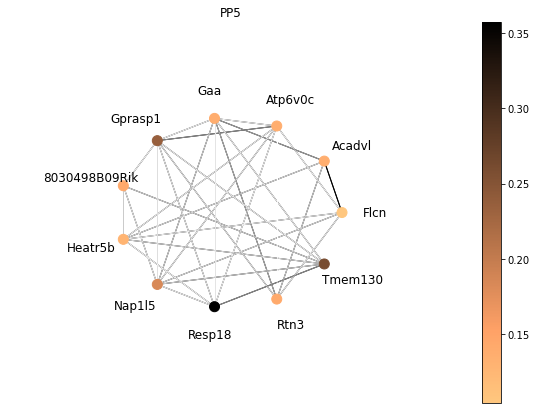

In [83]:
rf_loop = new_iRF(rf=rf, combination_rule='min', threshold=0.05)
for i in range(13):
    pps = [i]
    weights = np.mean(nmf.components_[pps], 0)
    selected_gene_ids = filter_genes(unique_coefs, pps, threshold=0.9975)
    X_of_interest = unique_X[selected_gene_ids,:].T
    selected_gene_names = unique_gene_names[selected_gene_ids]
    colors = (
        unique_coefs[selected_gene_ids, pps[0]]/
        np.sum(unique_coefs[selected_gene_ids], axis=1)
    )
    subsampling = np.random.choice(np.arange(X_of_interest.shape[0]), 3000, replace=False)
    rf_loop.fit(X_of_interest[subsampling])
    rf_loop.show(node_names=selected_gene_names, colors=colors, title=f"PP{i+1}")
    if i > 3:
        break